In [1]:
'''
Calculate the noise power spectrum for the dect images and compare to the reference
'''

'\nCalculate the noise power spectrum for the dect images and compare to the reference\n'

In [2]:
import glob
import os
import SimpleITK as sitk
import pandas as pd
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

In [3]:
def get_attrib_from_name(filename):
    filename = pathlib.Path(filename)
    
    basename = filename.stem
    method = filename.parents[0].name
    dose_rate = filename.parents[1].name
    
    name = basename.split('_')[0]
    if dose_rate == 'half':
        dose = 'low'
    else:
        raise ValueError('Unexpected dose: %s'%dose)
        
    if method == 'ensemble':
        method = 'Ensemble'
    elif method == 'fbp':
        method = 'FBP'
    elif method == 'l2' and 'all' in basename:
        method = 'L2 (universal)'
    elif method == 'l2' and not 'all' in basename:
        method = 'L2 (matched)'
    elif method == 'wgan' and 'all' in basename:
        method = 'WGAN (universal)'
    elif method == 'wgan' and not 'all' in basename:
        method = 'WGAN (matched)'
    else:
        raise ValueError('Unexpected method: %s'%method)
    
    return {'Image': name, 
            'Tag': '%s/%s'%(dose, method),
            'filename': filename}

In [4]:
def extract_patches_from_rois(img, roi, patch_size = [32, 32]):
    patches = []
    
    for islice in range(len(img)):
        coords = np.where(roi[islice] > 0)
        if len(coords[0]) == 0:
            continue
        
        ymin = coords[0].min()
        ymax = coords[0].max() + 1
        xmin = coords[1].min()
        xmax = coords[1].max() + 1
        
        if ymax - ymin < patch_size[0] or xmax - xmin < patch_size[1]:
            continue
        
        for iy in range(ymin, ymax - patch_size[0] + 1, patch_size[0]):
            for ix in range(xmin, xmax - patch_size[1] + 1, patch_size[1]):
                patches.append(img[islice, iy:iy+patch_size[0], ix:ix+patch_size[1]])
    
    return np.array(patches)

In [5]:
def extract_patches_auto(ref, img, patch_size = [32, 32], hu_range = [0, 240], max_ref_std = 25):
    iys = np.arange(0, ref.shape[1], patch_size[0])
    iys[iys > ref.shape[1] - patch_size[0]] = ref.shape[1] - patch_size[0]
    ixs = np.arange(0, ref.shape[2], patch_size[1])
    ixs[ixs > ref.shape[2] - patch_size[1]] = ref.shape[2] - patch_size[1]
    
    ref_patches = []
    img_patches = []
    
    for iy in iys:
        for ix in ixs:
            ref_patches.append(ref[:, iy:iy+patch_size[0], ix:ix+patch_size[1]])
            img_patches.append(img[:, iy:iy+patch_size[0], ix:ix+patch_size[1]])
    
    ref_patches = np.concatenate(ref_patches)
    img_patches = np.concatenate(img_patches)
    
    stds_ref = np.std(ref_patches, axis = (1,2))
    mean_ref = np.mean(ref_patches, axis = (1,2))
    lb_ref = np.percentile(ref_patches, 0, axis=(1,2))
    ub_ref = np.percentile(ref_patches, 100, axis=(1,2))
    
    inds = np.where((lb_ref > hu_range[0]) & (ub_ref < hu_range[1]) & (stds_ref < max_ref_std))
    
    stds_ref = stds_ref[inds]
    img_patches = img_patches[inds]
    inds = np.argsort(stds_ref)
    
    return img_patches[inds]

In [6]:
def estimate_nps(patches, r_step = 0.5, angle_step = 15):
    angle_step = angle_step * np.pi / 180
    
    n = patches.shape[1] * patches.shape[2]
    freq = np.abs(np.fft.fft2(patches / patches.mean((-1,-2))[:, np.newaxis, np.newaxis] - 1))**2 / n
    freq = np.mean(freq, 0)
    
    nps2d = freq[:freq.shape[0]//2, :freq.shape[1]//2]
    f = scipy.interpolate.interp2d(np.arange(nps2d.shape[1]), np.arange(nps2d.shape[0]), nps2d)
    
    nps1d_list = []
    for angle in np.arange(0, np.pi / 2 + 0.001, angle_step):
        nps1d = []
        for r in np.arange(0, nps2d.shape[0] + 0.001, r_step):
            nps1d.append(f(r * np.cos(angle), r * np.sin(angle)))
        nps1d_list.append(nps1d)
    nps1d_list = np.array(nps1d_list)
    
    return nps1d_list.mean(0)   

In [7]:
result_dir = '/home/dwu/trainData/deep_denoiser_ensemble/test/dect_2d_3_layer_mean/'
names = ['35', '56', '57', '58', '59', '60']
# names = ['60']

manifest = []
for name in names:
    for energy in ['b']:
        print (name, flush=True)
        result_list = [f for f in glob.glob(os.path.join(result_dir, '*/*', '%s*_%s.nii'%(name, energy))) if 'full' not in f]

        # load the reference image
        ref_sitk = sitk.ReadImage(os.path.join(result_dir, 'full/fbp/%s_%s.nii')%(name, energy))
        ref = sitk.GetArrayFromImage(ref_sitk)
        dx = ref_sitk.GetSpacing()[0]
        
        ref_roi = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(result_dir, 'full/roi/%s.nrrd')%name))
        ref_p = extract_patches_from_rois(ref, ref_roi)
        nps = estimate_nps(ref_p).squeeze()*dx*dx
        
        print (len(result_list), end=': ', flush=True)
        metric_manifests = [pd.DataFrame({'Image': [name] * len(nps), 
                                          'Frequency': np.arange(len(nps)) * (1 / 2 / dx) / (len(nps) - 1),
                                          'full/FBP': nps})]
        imgs = []
        for k, result_name in enumerate(result_list):
            print (k, end = ',', flush=True)

            attrib = get_attrib_from_name(result_name)
            img = sitk.GetArrayFromImage(sitk.ReadImage(result_name))
            img_roi = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(result_dir, 'half/roi/%s.nrrd')%name))
            img_p = extract_patches_from_rois(img, img_roi)
            
            imgs.append(img_p)
            nps = estimate_nps(img_p).squeeze()*dx*dx
            
            metric_manifests.append(pd.DataFrame({'Image': [attrib['Image']] * len(nps), 
                                                  'Frequency': np.arange(len(nps)) * (1 / 2 / dx) / (len(nps) - 1),
                                                  attrib['Tag']: nps}))
    
        print ('')

        # merge the manifests
        df = metric_manifests[0]
        for m in metric_manifests[1:]:
            df = pd.merge(df, m, on = ['Image', 'Frequency'])
        manifest.append(df)
        
manifest = pd.concat(manifest, ignore_index = True)
manifest.to_csv('./dect2d_nps.csv', index=False)

35
6: 0,1,2,3,4,5,
56
6: 0,1,2,3,4,5,
57
6: 0,1,2,3,4,5,
58
6: 0,1,2,3,4,5,
59
6: 0,1,2,3,4,5,
60
6: 0,1,2,3,4,5,


0.2880855298281562
0.3296284122390813
0.38996273814216376
0.2865329935938156
0.21153760194195104
0.2294788846172918
0.2756371843711873


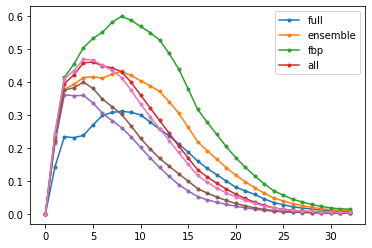

In [8]:
nps = []
for p in [ref_p] + imgs:
    print (np.std(p) / np.mean(p))
    nps.append(estimate_nps(p))

for nps_val in nps:
    plt.plot(nps_val, '.-')
plt.legend(['full', 'ensemble', 'fbp', 'all'])